In [121]:
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from boiler.constants import column_names
from boiler.data_processing.beetween_filter_algorithm import FullClosedTimestampFilterAlgorithm
from dateutil.tz import gettz

import config

In [122]:
# "engelsa_35.pickle" 6
# "engelsa_37.pickle" 6
# "gaydara_1.pickle" 3
# "gaydara_22.pickle" 2
# "gaydara_26.pickle" 4
# "gaydara_28.pickle" 5
# "gaydara_30.pickle" 5
# "gaydara_32.pickle" 5
# "kuibysheva_10.pickle" 3
# "kuibysheva_14.pickle" 3
# "kuibysheva_16.pickle" 3
# "kuibysheva_8.pickle" 3

In [123]:
start_datetime = datetime.datetime(2019, 2, 2, 0, 0, 0, tzinfo=gettz(config.DEFAULT_TIMEZONE))
end_datetime = datetime.datetime(2019, 4, 1, 0, 0, 0, tzinfo=gettz(config.DEFAULT_TIMEZONE))
forward_round_step = 0.1

dataset_name = "engelsa_37.pickle"
lag = 1

start_datetime = pd.Timestamp(start_datetime)
end_datetime = pd.Timestamp(end_datetime)

filter_algorithm = FullClosedTimestampFilterAlgorithm()

home_df = pd.read_pickle(f"{config.APARTMENT_HOUSE_PREPROCESSED_DATASETS_HEATING_CIRCUIT_DIR}\\{dataset_name}")
home_df = filter_algorithm.filter_df_by_min_max_timestamp(home_df, start_datetime, end_datetime)
home_forward_temp = home_df[column_names.FORWARD_TEMP].to_numpy()
home_backward_temp = home_df[column_names.BACKWARD_TEMP].to_numpy()
moved_backward_temp = home_backward_temp[:-lag]
moved_forward_temp = home_forward_temp[lag:]
temp_delta = moved_forward_temp-moved_backward_temp

weather_df = pd.read_pickle(f"{config.WEATHER_PREPROCESSED_DATASET_PATH}")
weather_df = filter_algorithm.filter_df_by_min_max_timestamp(weather_df, start_datetime, end_datetime)
weather_temp = weather_df[column_names.WEATHER_TEMP].to_numpy()
moved_weather_temp = weather_temp[lag:]

Min/Max/Mean std 0.0, 1.762922865182026, 0.8697079390004053
Min/Max/Mean temp_delta 3.3400001525878906, 24.450000762939453, 12.349570274353027


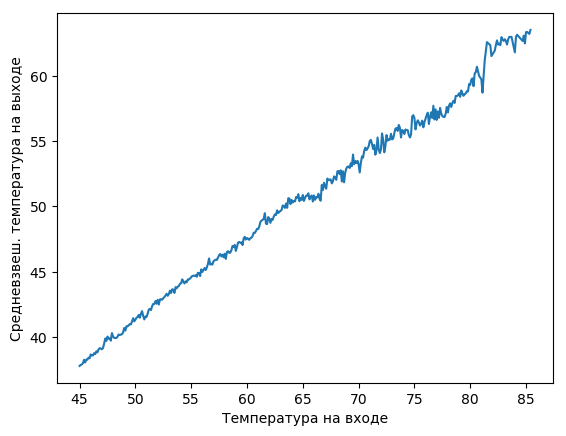

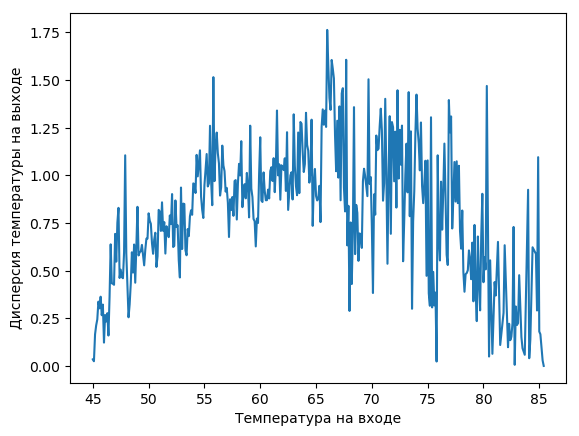

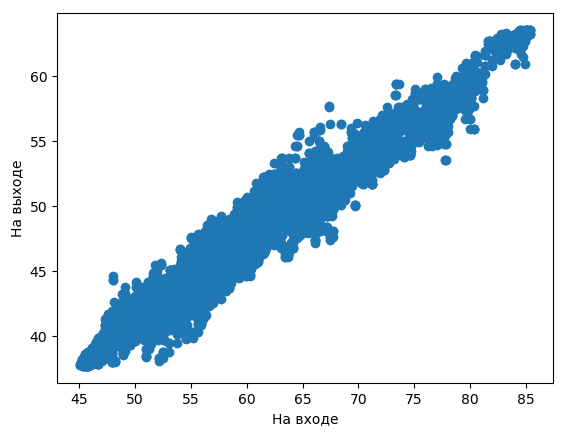

In [124]:
forward_column = "FORWARD_TEMP"
backward_column = "BACKWARD_TEMP"
forward_rounded_column = "FORWARD_ROUNDED"
mean_group_value_column = "MEAN_GROUP_TEMP"
std_group_value_column = "STD_GROUP"

correlation_df = pd.DataFrame({
    forward_column: moved_forward_temp,
    backward_column: moved_backward_temp
})

correlation_df[forward_rounded_column] = correlation_df[forward_column].apply(
    lambda x: x // forward_round_step * forward_round_step
)
mean_series = correlation_df.groupby(forward_rounded_column)[backward_column].mean()
correlation_df[mean_group_value_column] = correlation_df[forward_rounded_column].apply(
    lambda x: mean_series[x]
)
std_series = correlation_df.groupby(forward_rounded_column)[backward_column].std()
correlation_df[std_group_value_column] = correlation_df[forward_rounded_column].apply(
    lambda x: std_series[x]
)

correlation_df = correlation_df.sort_values(forward_rounded_column)
correlation_df = correlation_df[correlation_df[std_group_value_column].notnull()]
forward_temp = correlation_df[forward_rounded_column].to_numpy()
mean_temp = correlation_df[mean_group_value_column].to_numpy()
std_temp = correlation_df[std_group_value_column].to_numpy()

print(f"Min/Max/Mean std {std_temp.min()}, {std_temp.max()}, {std_temp.mean()}")
print(f"Min/Max/Mean temp_delta {temp_delta.min()}, {temp_delta.max()}, {temp_delta.mean()}")

plt.plot(forward_temp, mean_temp)
plt.xlabel("Температура на входе")
plt.ylabel("Средневзвеш. температура на выходе")
plt.show()

plt.plot(forward_temp, std_temp)
plt.xlabel("Температура на входе")
plt.ylabel("Дисперсия температуры на выходе")
plt.show()

plt.scatter(moved_forward_temp, moved_backward_temp)
plt.xlabel("На входе")
plt.ylabel("На выходе")
plt.show()

Min/Max/Mean std 0.03535479957966644, 2.885224396203946, 1.3811185299039381
Min/Max/Mean temp_delta 3.3400001525878906, 24.450000762939453, 12.349570274353027


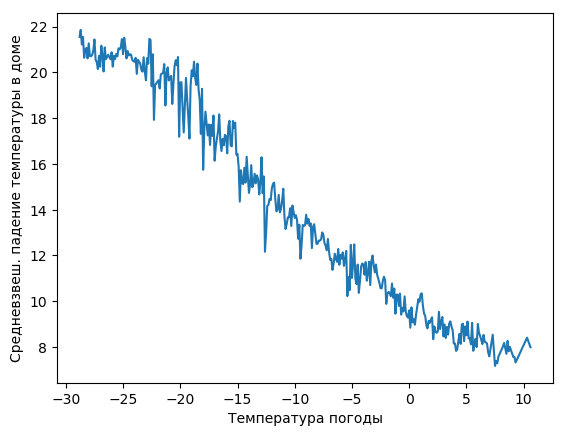

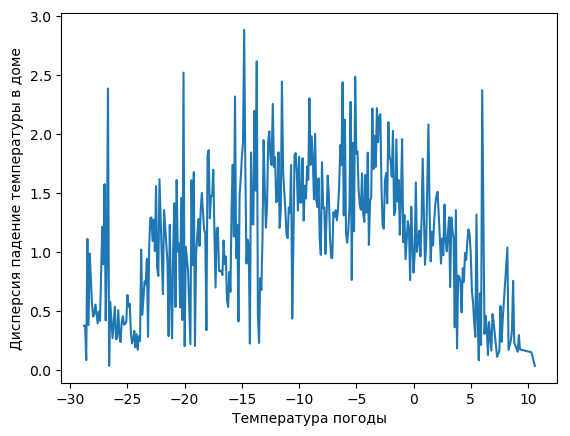

In [125]:
weather_column = "WEATHER_TEMP"
weather_rounded_column = "WEATHER_ROUNDED"
temp_delta_column = "TEMP_DELTA"
mean_group_value_column = "MEAN_GROUP_TEMP"
std_group_value_column = "STD_GROUP"

temp_delta = moved_forward_temp-moved_backward_temp

correlation_df = pd.DataFrame({
    weather_column: moved_weather_temp,
    temp_delta_column: temp_delta
})

correlation_df[weather_rounded_column] = correlation_df[weather_column].apply(
    lambda x: x // forward_round_step * forward_round_step
)
mean_series = correlation_df.groupby(weather_rounded_column)[temp_delta_column].mean()
correlation_df[mean_group_value_column] = correlation_df[weather_rounded_column].apply(
    lambda x: mean_series[x]
)
std_series = correlation_df.groupby(weather_rounded_column)[temp_delta_column].std()
correlation_df[std_group_value_column] = correlation_df[weather_rounded_column].apply(
    lambda x: std_series[x]
)

correlation_df = correlation_df.sort_values(weather_rounded_column)
correlation_df = correlation_df[correlation_df[std_group_value_column].notnull()]
weather_rouned_temp = correlation_df[weather_rounded_column].to_numpy()
mean_temp = correlation_df[mean_group_value_column].to_numpy()
std_temp = correlation_df[std_group_value_column].to_numpy()

temp_delta = moved_forward_temp-moved_backward_temp

print(f"Min/Max/Mean std {std_temp.min()}, {std_temp.max()}, {std_temp.mean()}")
print(f"Min/Max/Mean temp_delta {temp_delta.min()}, {temp_delta.max()}, {temp_delta.mean()}")

plt.plot(weather_rouned_temp, mean_temp)
plt.xlabel("Температура погоды")
plt.ylabel("Средневзвеш. падение температуры в доме")
plt.show()

plt.plot(weather_rouned_temp, std_temp)
plt.xlabel("Температура погоды")
plt.ylabel("Дисперсия падение температуры в доме")
plt.show()

[[ 1.        -0.8902863]
 [-0.8902863  1.       ]]


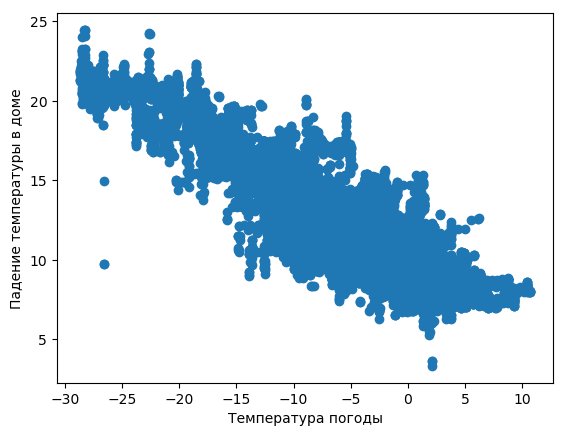

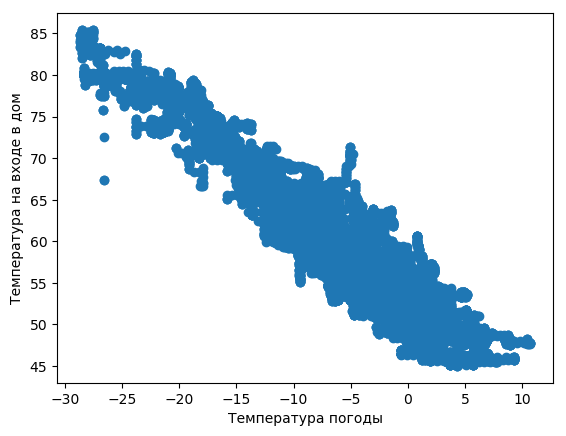

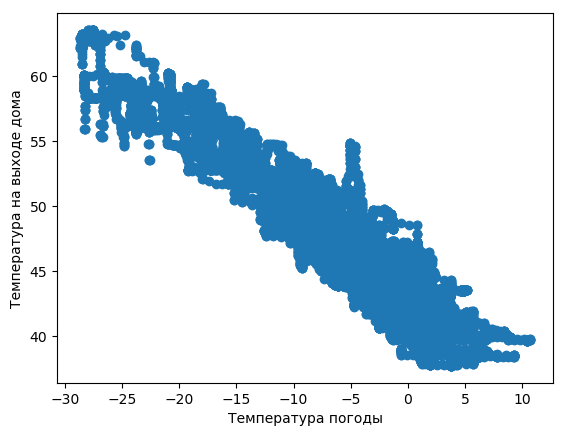

In [130]:
print(np.corrcoef(moved_weather_temp, temp_delta))

plt.scatter(moved_weather_temp, temp_delta)
plt.xlabel("Температура погоды")
plt.ylabel("Падение температуры в доме")
plt.show()

plt.scatter(moved_weather_temp, moved_forward_temp)
plt.xlabel("Температура погоды")
plt.ylabel("Температура на входе в дом")
plt.show()

plt.scatter(moved_weather_temp, moved_backward_temp)
plt.xlabel("Температура погоды")
plt.ylabel("Температура на выходе дома")
plt.show()